<a href="https://colab.research.google.com/github/5hyfilm/deeplearning-ca/blob/main/binary_squeezenet_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check GPU

In [ ]:
!nvidia-smi

Tue Jul 20 10:51:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, compute_sample_weight, compute_class_weight
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

import pandas as pd
import numpy as np
import os
import shutil
import math
import itertools
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns
import json
import cv2

In [ ]:
tf.compat.v1.disable_eager_execution()

# Data Preparation

In [ ]:
!git clone https://github.com/5HYFILM-DATA/deeplearning-ca-dataset-2

Cloning into 'deeplearning-ca-dataset-2'...
remote: Enumerating objects: 1816, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 1816 (delta 5), reused 15 (delta 5), pack-reused 1801
Receiving objects: 100% (1816/1816), 1.01 GiB | 39.75 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Checking out files: 100% (3312/3312), done.


In [ ]:
model_name = 'binary_squeezenet'
base = '/content/deeplearning-ca-dataset-2'
base_data = os.path.join(base, 'data_for_train')
base_output = os.path.join(model_name + '_output', model_name + '_result')

dataset_types = ['train', 'test', 'validate']
categories = ['cancerpmd', 'normal']

In [ ]:
if not os.path.exists(base_data):
    os.makedirs(base_data, exist_ok=True)
if not os.path.exists(base_output):
    os.makedirs(base_output, exist_ok=True)

In [ ]:
datasets = {dataset_type:[] for dataset_type in dataset_types}
for category in categories:
    df = pd.read_json(os.path.join(base, 'dataset_{}_augment.json'.format(category)))
    for dataset_type in dataset_types:
        datasets[dataset_type].append(df[df['type']==dataset_type])

for dataset_type in datasets:
    df = pd.concat(datasets[dataset_type])
    df['file_name'] = base+"/image/"+df['category']+"/"+df['file_name']
    datasets[dataset_type] = df

In [ ]:
train_aug = ImageDataGenerator(rescale=1./255)

val_aug = ImageDataGenerator(rescale=1./255)

test_aug = ImageDataGenerator(rescale=1./255)

## Hyperparameters

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
EPOCHS = 100
BATCH_SIZE = 32
LR = 1e-5 # Learning rate

In [ ]:
train_generator = train_aug.flow_from_dataframe(datasets['train'],
                                                x_col='file_name',
                                                y_col='category',
                                                target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                                batch_size=BATCH_SIZE, 
                                                shuffle=True,
                                                class_mode='sparse') 

val_generator = val_aug.flow_from_dataframe(datasets['validate'],
                                                x_col='file_name',
                                                y_col='category',
                                                target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                                batch_size=BATCH_SIZE, 
                                                shuffle=True,
                                                class_mode='sparse') 

test_generator = test_aug.flow_from_dataframe(datasets['test'],
                                                x_col='file_name',
                                                y_col='category',
                                                target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                                batch_size=1, 
                                                shuffle=False,
                                                class_mode='sparse')

Found 1360 validated image filenames belonging to 2 classes.
Found 196 validated image filenames belonging to 2 classes.
Found 392 validated image filenames belonging to 2 classes.


In [ ]:
NUM_CLASSES = len(train_generator.class_indices)

# Model

## Build Model

In [ ]:
def fire(x, squeeze, expand):
  y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
  y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
  y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(y) 
  y1 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y1)
  y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(y)
  y3 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y3)
  return tf.keras.layers.concatenate([y1, y3])

def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)

In [ ]:
bnmomemtum=0.9

In [ ]:
x = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3]) # input is 224x224 pixels RGB

y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(64, 128)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(y)

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
model = tf.keras.Model(x, y)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 24) 792         batch_normalization[0][0]        
______________________________________________________________________________________________

## Compile

In [ ]:
model.compile(optimizer=Adam(LR), 
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

## Callbacks

In [ ]:
model_path = os.path.join(base_output, "{}_model.h5".format(model_name))

In [ ]:
early_stop = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10, verbose=0, mode='max')

model_checkpoint = ModelCheckpoint(filepath=model_path, save_best_only=True, monitor='val_loss', mode='min')

reduce_lr_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_lr=1e-7, patience=10, verbose=1, min_delta=1e-4, mode='min')

## Training

In [ ]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=EPOCHS,
                    callbacks=[early_stop, model_checkpoint, reduce_lr_rate],
                    verbose=1)

Epoch 1/100
43/43 [==============================] - ETA: 0s - batch: 21.0000 - size: 31.6279 - loss: 7.4150 - sparse_categorical_accuracy: 0.6250

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


43/43 [==============================] - 129s 2s/step - batch: 21.0000 - size: 31.6279 - loss: 7.4150 - sparse_categorical_accuracy: 0.6250 - val_loss: 7.3713 - val_sparse_categorical_accuracy: 0.6582 - lr: 1.0000e-05
Epoch 2/100
43/43 [==============================] - 95s 2s/step - batch: 21.0000 - size: 31.6279 - loss: 7.3563 - sparse_categorical_accuracy: 0.6809 - val_loss: 7.2696 - val_sparse_categorical_accuracy: 0.7908 - lr: 1.0000e-05
Epoch 3/100
43/43 [==============================] - 97s 2s/step - batch: 21.0000 - size: 31.6279 - loss: 7.3191 - sparse_categorical_accuracy: 0.7140 - val_loss: 7.2328 - val_sparse_categorical_accuracy: 0.8112 - lr: 1.0000e-05
Epoch 4/100
43/43 [==============================] - 97s 2s/step - batch: 21.0000 - size: 31.6279 - loss: 7.2670 - sparse_categorical_accuracy: 0.7382 - val_loss: 7.1563 - val_sparse_categorical_accuracy: 0.8265 - lr: 1.0000e-05
Epoch 5/100
43/43 [==============================] - 97s 2s/step - batch: 21.0000 - size: 31.62

# Training Graph

## Accuracy

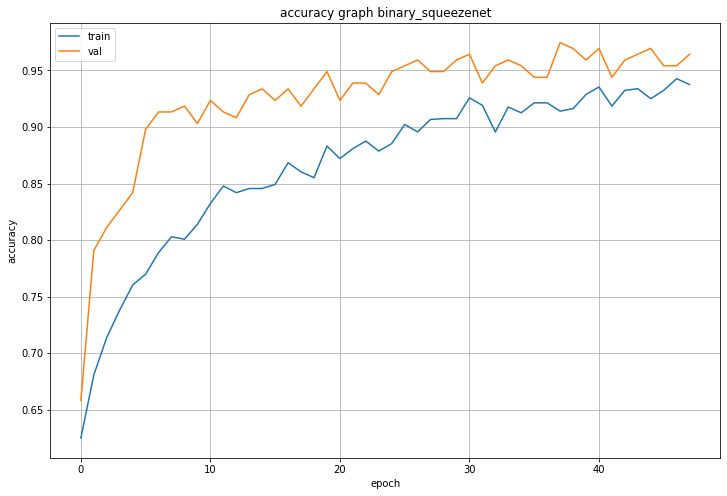

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy graph {}'.format(model_name))
plt.grid()
plt.savefig(os.path.join(base_output, '{}_accuracy_graph'.format(model_name)))
plt.show()

## Loss

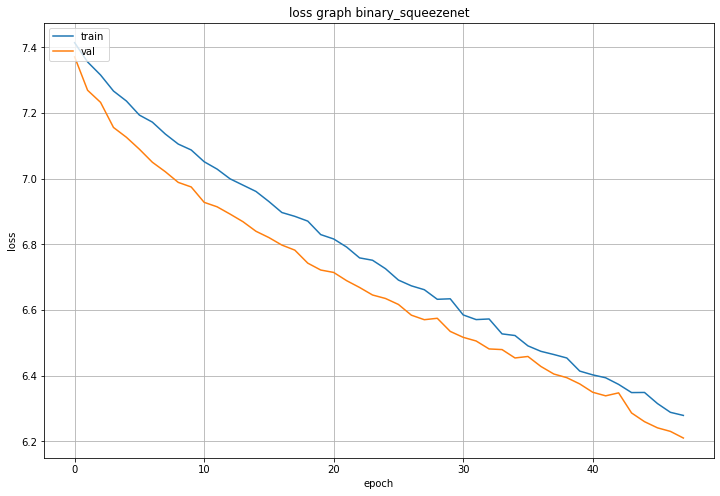

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss graph {}'.format(model_name))
plt.grid()
plt.savefig(os.path.join(base_output, '{}_loss_graph'.format(model_name)))
plt.show()

# Evaluation

In [ ]:
test_model = tf.keras.models.load_model(model_path)

In [ ]:
num_test_files = len(test_generator.filenames)

In [ ]:
test_generator.reset()

## Confusion Matrix


In [ ]:
test_labels = test_generator.classes
predictions = test_model.predict(test_generator, steps=num_test_files//test_generator.batch_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

### Without Normalize

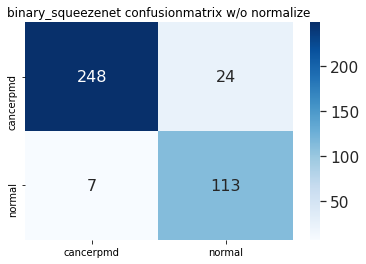

In [ ]:
plt.title('{} confusionmatrix w/o normalize'.format(model_name))
df_cm = pd.DataFrame(cm, categories, categories)
sns.set(font_scale=1.4)
fig = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap="Blues")
fig.figure.savefig(os.path.join(base_output, '{}_confusionmatrix_wo_normalize'.format(model_name)))

### With Normalize

In [ ]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

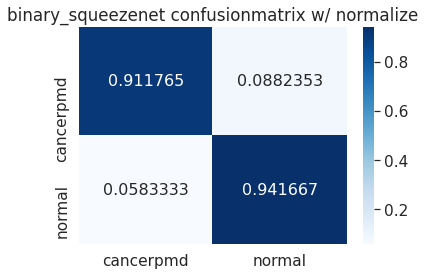

In [ ]:
plt.title('{} confusionmatrix w/ normalize'.format(model_name))
df_cm = pd.DataFrame(cm, categories, categories)
sns.set(font_scale=1.4)
fig = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap="Blues")
fig.figure.savefig(os.path.join(base_output, '{}_confusionmatrix_w_normalize'.format(model_name)))

## Classification Report

In [ ]:
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix {}'.format(model_name))
print(confusion_matrix(test_labels, y_pred))
print('Classification Report {}'.format(model_name))
print(classification_report(test_labels, y_pred, target_names=categories))

Confusion Matrix binary_squeezenet
[[248  24]
 [  7 113]]
Classification Report binary_squeezenet
              precision    recall  f1-score   support

   cancerpmd       0.97      0.91      0.94       272
      normal       0.82      0.94      0.88       120

    accuracy                           0.92       392
   macro avg       0.90      0.93      0.91       392
weighted avg       0.93      0.92      0.92       392



## TP FP FN TN

In [ ]:
cm_2 = confusion_matrix(test_labels, y_pred)

### TP

In [ ]:
TruePositive= np.diag(cm_2)

In [ ]:
print(TruePositive)
sumTruePositive = sum(TruePositive)
print('Sum of True Positive: ', sumTruePositive)

[248 113]
Sum of True Positive:  361


### FP

In [ ]:
FalsePositive = []
for i in range(NUM_CLASSES):
    FalsePositive.append(sum(cm_2[:,i]) - cm_2[i,i])

In [ ]:
print(FalsePositive)
sumFalsePositive = sum(FalsePositive)
print('Sum of False Positive: ', sumFalsePositive)

[7, 24]
Sum of False Positive:  31


### FN

In [ ]:
FalseNegative = []
for i in range(NUM_CLASSES):
    FalseNegative.append(sum(cm_2[i,:]) - cm_2[i,i])

In [ ]:
print(FalseNegative)
sumFalseNegative = sum(FalseNegative)
print('Sum of False Negative: ', sumFalseNegative)

[24, 7]
Sum of False Negative:  31


### TN

In [ ]:
TrueNegative = []
for i in range(NUM_CLASSES):
    temp = np.delete(cm_2, i, 0)   # delete ith row
    temp = np.delete(temp, i, 1)  # delete ith column
    TrueNegative.append(sum(sum(temp)))

In [ ]:
print(TrueNegative)
sumTrueNegative = sum(TrueNegative)
print('Sum of True Negative: ', sumTrueNegative)

[113, 248]
Sum of True Negative:  361


### Check TP + FP + FN + TN = Test set

In [ ]:
l = len(test_labels)
for i in range(NUM_CLASSES):
    print(TruePositive[i] + FalsePositive[i] + FalseNegative[i] + TrueNegative[i] == l)

True
True


## PYCM

In [ ]:
!pip3 install pycm==3.0 

     |████████████████████████████████| 61 kB 632 kB/s 
     |████████████████████████████████| 571 kB 13.8 MB/s 


In [ ]:
from pycm import *

In [ ]:
test_labels = test_generator.classes

In [ ]:
py_cm = ConfusionMatrix(actual_vector=test_labels, predict_vector=y_pred)

In [ ]:
py_cm.classes

[0, 1]

In [ ]:
py_cm.table

{0: {0: 248, 1: 24}, 1: {0: 7, 1: 113}}

### Sensitivity

In [ ]:
AV_Sens = (py_cm.TPR[0] + py_cm.TPR[1])/len(py_cm.TPR)

In [ ]:
print('Sensitivity of', categories[0], py_cm.TPR[0])
print('Sensitivity of', categories[1], py_cm.TPR[1])
print('Average Sensitivity: ', AV_Sens)

Sensitivity of cancerpmd 0.9117647058823529
Sensitivity of normal 0.9416666666666667
Average Sensitivity:  0.9267156862745098


### Specificity

In [ ]:
AV_Spec = (py_cm.TNR[0] + py_cm.TNR[1])/len(py_cm.TNR)

In [ ]:
print('Specificity of', categories[0], py_cm.TNR[0])
print('Specificity of', categories[1], py_cm.TNR[1])
print('Average Specificity: ', AV_Spec)

Specificity of cancerpmd 0.9416666666666667
Specificity of normal 0.9117647058823529
Average Specificity:  0.9267156862745098


## Curve

### Receiver Operating Characteristic curve
from: https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

Average Receiver Operating Characteristic AUC:  0.9840379901960785


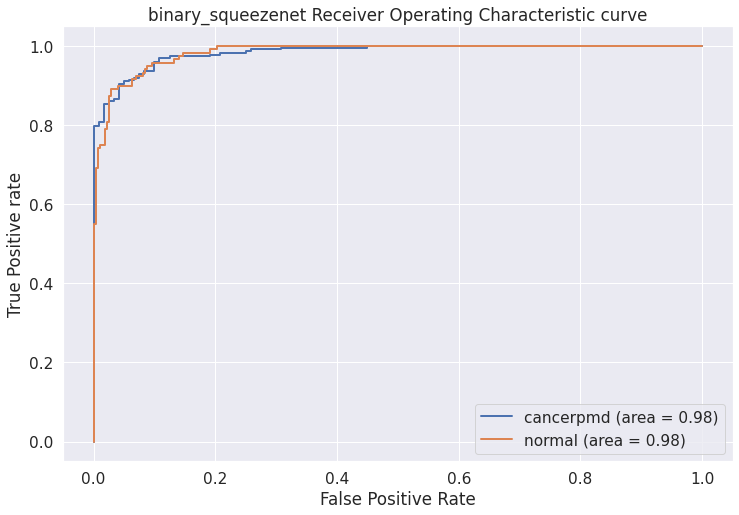

In [ ]:
fpr = {}
tpr = {}
thresh ={}
roc_auc_list = []

plt.figure(figsize=(12, 8))
for i in range(NUM_CLASSES):    
    fpr[i], tpr[i], thresh[i] = roc_curve(test_generator.classes, predictions[:,i], pos_label=i)
    roc_auc = auc(fpr[i], tpr[i])
    roc_auc_list.append(roc_auc)
    plt.plot(fpr[i], tpr[i], lw=2, label='{} (area = %0.2f)'.format(categories[i]) % roc_auc)
plt.title('{} Receiver Operating Characteristic curve'.format(model_name))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig(os.path.join(base_output, '{}_roc_curve'.format(model_name)))

av_roc_auc = sum(roc_auc_list) / len(roc_auc_list)
print('Average Receiver Operating Characteristic AUC: ', av_roc_auc)

### Precision-Recall curve
from: https://stackoverflow.com/a/56092736/9956949

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

Average Precision-Recall AUC:  0.9799128097548435


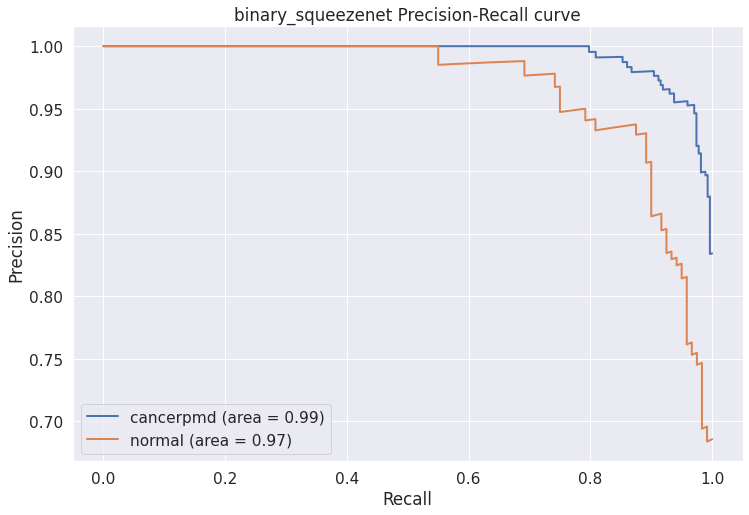

In [ ]:
precision = {}
recall = {}
pr_auc_list = []

plt.figure(figsize=(12, 8))
for i in range(NUM_CLASSES):
    precision[i], recall[i], _ = precision_recall_curve(test_generator.classes, predictions[:,i], pos_label=i)
    pr_auc = auc(recall[i], precision[i])
    pr_auc_list.append(pr_auc)
    plt.plot(recall[i], precision[i], lw=2, label='{} (area = %0.2f)'.format(categories[i]) % pr_auc)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("{} Precision-Recall curve".format(model_name))
plt.savefig(os.path.join(base_output, '{}_pr_curve'.format(model_name)))

av_pr_auc = sum(pr_auc_list) / len(pr_auc_list)
print('Average Precision-Recall AUC: ', av_pr_auc)

## Grad-CAM

In [ ]:
last_conv2d = 'conv2d_15'

In [ ]:
def load_image(path, preprocess=True):
    """Load and preprocess image."""
    x = image.load_img(path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    if preprocess:
        x = image.img_to_array(x)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
    return x

In [ ]:
def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

In [ ]:
def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    x = x.copy()
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)
    # convert to RGB array
    x *= 255
    if tf.keras.backend.image_data_format() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
def my_decode_predictions(preds, top=3, class_list_path='/content/deeplearning-ca-dataset-2/binary_index.json'):
    if len(preds.shape) != 2 or preds.shape[1] != 3:
        raise ValueError('`my_decode_predictions` expects '
                     'a batch of predictions '
                     '(i.e. a 2D array of shape (samples, 1000)). '
                     'Found array with shape: ' + str(preds.shape))
    CLASS_INDEX = json.load(open(class_list_path))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results

In [ ]:
def guided_backprop(input_model, images, layer_name):
    """Guided Backpropagation method for visualizing input saliency."""
    input_imgs = input_model.input
    layer_output = input_model.get_layer(layer_name).output
    grads = tf.gradients(layer_output, input_imgs)[0]
    backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
    grads_val = backprop_fn([images, 0])[0]
    return grads_val

In [ ]:
def grad_cam(input_model, image, cls, layer_name):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = tf.gradients(y_c, conv_output)[0]
    # Normalize if necessary
    # grads = normalize(grads)
    gradient_function = K.function([input_model.input], [conv_output, grads])
    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)
    # Process CAM
    cam = cv2.resize(cam, (IMG_WIDTH, IMG_HEIGHT), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

In [ ]:
def grad_cam_batch(input_model, images, classes, layer_name):
    """GradCAM method for visualizing input saliency.
    Same as grad_cam but processes binaryple images in one run."""
    loss = tf.gather_nd(input_model.output, np.dstack([range(images.shape[0]), classes])[0])
    layer_output = input_model.get_layer(layer_name).output
    grads = tf.gradients(loss, layer_output)[0]
    gradient_fn = K.function([input_model.input, K.learning_phase()], [layer_output, grads])
    conv_output, grads_val = gradient_fn([images, 0])    
    weights = np.mean(grads_val, axis=(1, 2))
    cams = np.einsum('ijkl,il->ijk', conv_output, weights)
    # Process CAMs
    new_cams = np.empty((images.shape[0], IMG_HEIGHT, IMG_WIDTH))
    for i in range(new_cams.shape[0]):
        cam_i = cams[i] - cams[i].mean()
        cam_i = (cam_i + 1e-10) / (np.linalg.norm(cam_i, 2) + 1e-10)
        new_cams[i] = cv2.resize(cam_i, (IMG_WIDTH, IMG_HEIGHT), cv2.INTER_LINEAR)
        new_cams[i] = np.maximum(new_cams[i], 0)
        new_cams[i] = new_cams[i] / new_cams[i].max()
    return new_cams

In [ ]:
def compute_saliency(model, guided_model, img_path, layer_name=None, cls=-1, visualize=True, save=True):
    """Compute saliency using all three approaches.
        -layer_name: layer to compute gradients;
        -cls: class number to localize (-1 for most probable class).
    """
    preprocessed_input = load_image(img_path)
    predictions = model.predict(preprocessed_input)
    top_n = 5
    top = my_decode_predictions(predictions, top=top_n)[0]
    classes = np.argsort(predictions[0])[-top_n:][::-1]
    print('Model prediction:')
    for c, p in zip(classes, top):
        print('\t{:15s}\t({})\twith probability {:.3f}'.format(p[1], c, p[2]))
    if cls == -1:
        cls = np.argmax(predictions)
    class_name = my_decode_predictions(np.eye(1, 3, cls))[0][0][1]
    print("Explanation for '{}'".format(class_name))  
    gradcam = grad_cam(model, preprocessed_input, cls, layer_name)
    gb = guided_backprop(guided_model, preprocessed_input, layer_name)
    guided_gradcam = gb * gradcam[..., np.newaxis]
    if save:
        jetcam = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
        jetcam = (np.float32(jetcam) + load_image(img_path, preprocess=False)) / 2
        cv2.imwrite('gradcam_{}.jpg'.format(img_path), np.uint8(jetcam))
        cv2.imwrite('guided_backprop_{}.jpg'.format(img_path), deprocess_image(gb[0]))
        cv2.imwrite('guided_gradcam_{}.jpg'.format(img_path), deprocess_image(guided_gradcam[0]))
    if visualize:
        plt.figure(figsize=(15, 10))
        plt.subplot(131)
        plt.title('GradCAM of {}'.format(img_path))
        plt.axis('off')
        plt.imshow(load_image(img_path, preprocess=False))
        plt.imshow(gradcam, cmap='jet', alpha=0.5)
        plt.subplot(132)
        plt.title('Guided Backprop of {}'.format(img_path))
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(gb[0]), -1))
        plt.subplot(133)
        plt.title('Guided GradCAM of {}'.format(img_path))
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(guided_gradcam[0]), -1))
        plt.show()      
    return gradcam, gb, guided_gradcam

### Cancer

In [ ]:
cancer_img = '/content/deeplearning-ca-dataset-2/image/cancer/Cancer_A_4_U5QEvnm_augment2.jpg'
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, cancer_img, layer_name=last_conv2d)

ValueError: ignored

### Normal

In [ ]:
normal_img = '/content/deeplearning-ca-dataset-2/image/normal/normal-0.jpg'
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, normal_img, layer_name=last_conv2d)

### PMD

In [ ]:
pmd_img = '/content/deeplearning-ca-dataset-2/image/pmd/PMD_A_3.jpg'
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, pmd_img, layer_name=last_conv2d)

# Download Model

In [ ]:
from google.colab import files

In [ ]:
shutil.move(base_output, "/content/") 

'/content/binary_squeezenet_result'

In [ ]:
!zip -r /content/binary_squeezenet_result.zip /content/binary_squeezenet_result

  adding: content/binary_squeezenet_result/ (stored 0%)
  adding: content/binary_squeezenet_result/binary_squeezenet_loss_graph.png (deflated 7%)
  adding: content/binary_squeezenet_result/binary_squeezenet_accuracy_graph.png (deflated 6%)
  adding: content/binary_squeezenet_result/binary_squeezenet_confusionmatrix_wo_normalize.png (deflated 9%)
  adding: content/binary_squeezenet_result/binary_squeezenet_confusionmatrix_w_normalize.png (deflated 6%)
  adding: content/binary_squeezenet_result/binary_squeezenet_model.h5 (deflated 23%)
  adding: content/binary_squeezenet_result/binary_squeezenet_pr_curve.png (deflated 12%)
  adding: content/binary_squeezenet_result/binary_squeezenet_roc_curve.png (deflated 15%)


In [ ]:
files.download('/content/binary_squeezenet_result.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>